In [1]:
#Import Libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from dataset import get_loader
from transform import get_a_train_transform, get_a_test_transform
from utils import get_device
from utils import compute_mean_std

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = datasets.CIFAR10('./data', train=True, download=True)
test_data = datasets.CIFAR10('./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
# Run only once initially to get mean and std.
# Data statistics
train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

print('[Train]')
print(' - Numpy Shape:', train.data.shape)

mean_, std_ = compute_mean_std(train)
print(' - Mean of 3 channels', mean_)
print(' - Std of 3 channels', std_)


Files already downloaded and verified
[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Mean of 3 channels (0.49139968, 0.48215827, 0.44653124)
 - Std of 3 channels (0.24703233, 0.24348505, 0.26158768)


In [3]:
class_map = train_data.class_to_idx
class_map

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [4]:
use_cuda, use_mps, device = get_device()

In [5]:
# Train/Test Loader
train_data, test_data, train_loader, test_loader = get_loader(train_data, test_data, get_a_train_transform(), get_a_test_transform(), batch_size=512, use_cuda=use_cuda, use_mps=use_mps)

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print('images in batch and shape of an image', images.shape)
print('labels : ', labels.shape)

images in batch and shape of an image torch.Size([512, 3, 32, 32])
labels :  torch.Size([512])


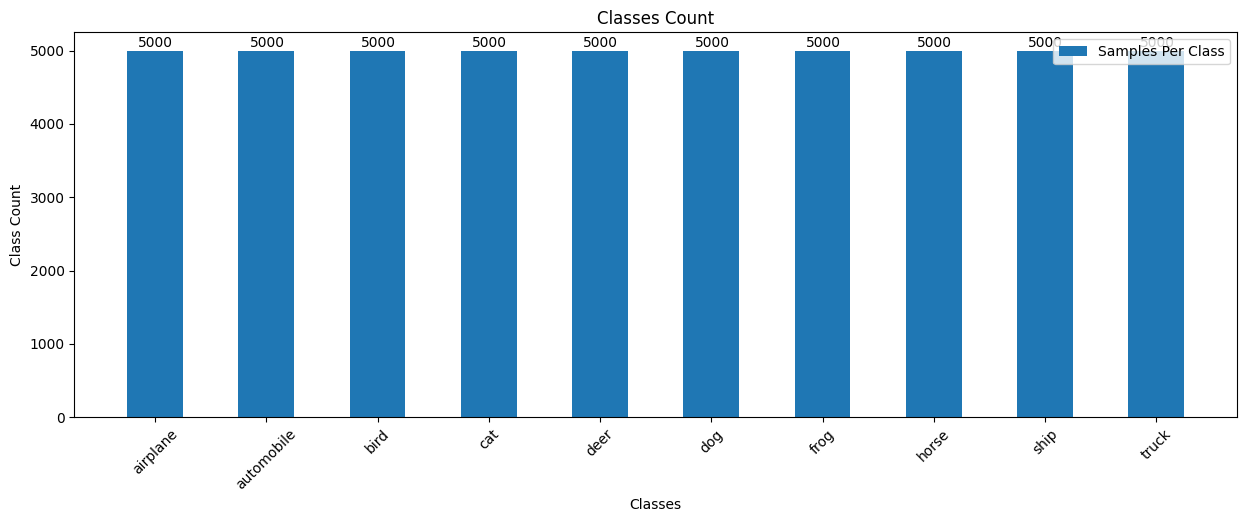

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

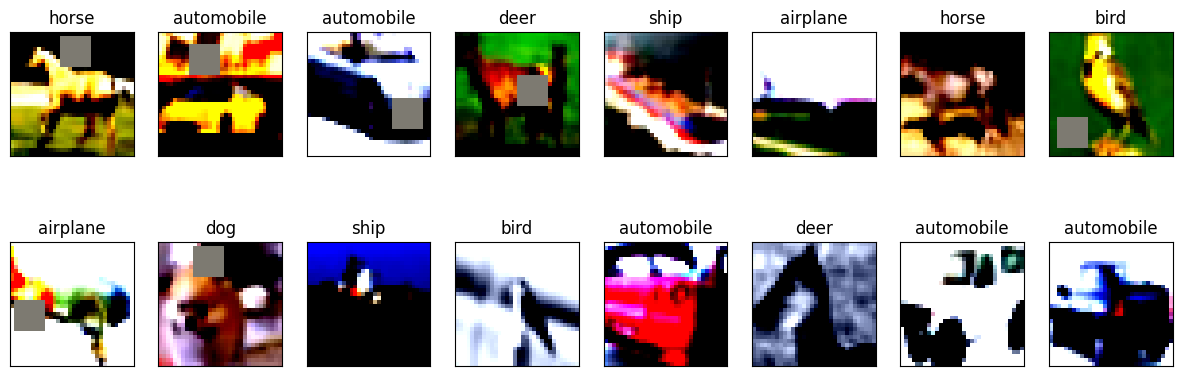

In [10]:
from visualise import print_class_scale, print_samples

torch.manual_seed(1)
show_dataset_analyze = True

if show_dataset_analyze:
    print_class_scale(train_loader, class_map)
    print_samples(train_loader, class_map, count=16)

In [6]:
from custom_resnet import CustomResnet
from utils import model_summary

show_summary = True

model = CustomResnet(device, norm="bn").to(device)
if show_summary:
    model_summary(model, (3,32,32))
#Total params: 149,546 After implementing Depthwise params reduced by 8k | implemented in layer 22,23

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

# One Cycle Policy

Keeping Onecycle LR related code non Moduler as it is first time I am using it. So wanted the implementation to be interactive.

In [7]:
from model_train import get_lr
from torch_lr_finder import LRFinder

#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)

#criterion = F.nll_loss
criterion = nn.CrossEntropyLoss(reduction="sum")

lr_finder = LRFinder(model, optimizer, criterion, device)

/Users/qureshsu/.local/share/virtualenvs/S6-JNyiktla/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


 68%|██████▊   | 136/200 [01:18<00:36,  1.74it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 4.65E-02


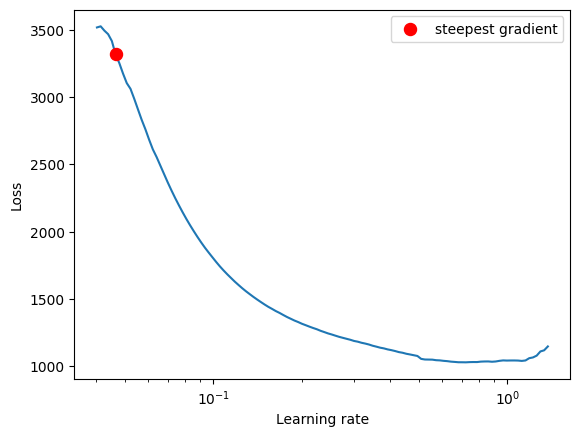

In [11]:
#torch.autograd.set_detect_anomaly(True)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot()
lr_finder.reset() # Never forget running this brfore starting training. 

In [8]:
from torch.optim.lr_scheduler import OneCycleLR
from model_train import model_train
from model_test import model_test

path = "trained_model/cifar10.pth"

EPOCHS = 24

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=23, gamma=0.1, verbose=True)

scheduler = OneCycleLR(
    optimizer,
    max_lr = 4.02E-02,
    steps_per_epoch = len(train_loader),
    epochs = EPOCHS,
    pct_start = 5/EPOCHS,
    div_factor = 100,
    three_phase = False,
    final_div_factor = 100,
    anneal_strategy = "linear"
)

for epoch in range(1, EPOCHS+1):
    print("Epoch ", epoch)
    model_train(model, device, train_loader, optimizer, criterion, scheduler, path)
    model_test(model, device, test_loader, criterion)

Epoch  1


  0%|          | 0/98 [00:00<?, ?it/s]

Train: Loss=322.1025 Batch_id=97 Accuracy=52.08: 100%|██████████| 98/98 [01:26<00:00,  1.14it/s]



Test set: Average loss: 1.1103, Accuracy: 6203/10000 (62.03%)

Epoch  2


Train: Loss=276.1741 Batch_id=97 Accuracy=68.32: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]



Test set: Average loss: 1.0714, Accuracy: 6789/10000 (67.89%)

Epoch  3


Train: Loss=236.9651 Batch_id=97 Accuracy=73.76: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s]



Test set: Average loss: 0.8658, Accuracy: 7245/10000 (72.45%)

Epoch  4


Train: Loss=272.2505 Batch_id=97 Accuracy=77.68: 100%|██████████| 98/98 [03:19<00:00,  2.04s/it]



Test set: Average loss: 0.8228, Accuracy: 7577/10000 (75.77%)

Epoch  5


Train: Loss=206.1631 Batch_id=97 Accuracy=80.80: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s]



Test set: Average loss: 1.1130, Accuracy: 7198/10000 (71.98%)

Epoch  6


Train: Loss=141.8673 Batch_id=97 Accuracy=83.14: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]



Test set: Average loss: 0.4798, Accuracy: 8366/10000 (83.66%)

Epoch  7


Train: Loss=143.5820 Batch_id=97 Accuracy=85.44: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]



Test set: Average loss: 0.4788, Accuracy: 8422/10000 (84.22%)

Epoch  8


Train: Loss=119.9904 Batch_id=97 Accuracy=87.05: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]



Test set: Average loss: 0.4550, Accuracy: 8533/10000 (85.33%)

Epoch  9


Train: Loss=101.5091 Batch_id=97 Accuracy=87.71: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]



Test set: Average loss: 0.4098, Accuracy: 8690/10000 (86.90%)

Epoch  10


Train: Loss=109.4460 Batch_id=97 Accuracy=89.12: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]



Test set: Average loss: 0.5251, Accuracy: 8483/10000 (84.83%)

Epoch  11


Train: Loss=96.9818 Batch_id=97 Accuracy=90.14: 100%|██████████| 98/98 [01:04<00:00,  1.53it/s] 



Test set: Average loss: 0.4272, Accuracy: 8724/10000 (87.24%)

Epoch  12


Train: Loss=79.0889 Batch_id=97 Accuracy=90.68: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s] 



Test set: Average loss: 0.3372, Accuracy: 8861/10000 (88.61%)

Epoch  13


Train: Loss=67.3728 Batch_id=97 Accuracy=91.74: 100%|██████████| 98/98 [01:05<00:00,  1.50it/s] 



Test set: Average loss: 0.4377, Accuracy: 8725/10000 (87.25%)

Epoch  14


Train: Loss=60.1335 Batch_id=97 Accuracy=92.41: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s] 



Test set: Average loss: 0.3513, Accuracy: 8866/10000 (88.66%)

Epoch  15


Train: Loss=59.2858 Batch_id=97 Accuracy=92.96: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s] 



Test set: Average loss: 0.3274, Accuracy: 8952/10000 (89.52%)

Epoch  16


Train: Loss=50.9755 Batch_id=97 Accuracy=93.53: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s] 



Test set: Average loss: 0.4835, Accuracy: 8693/10000 (86.93%)

Epoch  17


Train: Loss=71.8257 Batch_id=97 Accuracy=94.52: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s] 



Test set: Average loss: 0.3301, Accuracy: 9034/10000 (90.34%)

Epoch  18


Train: Loss=44.3354 Batch_id=97 Accuracy=95.30: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s] 



Test set: Average loss: 0.3174, Accuracy: 9077/10000 (90.77%)

Epoch  19


Train: Loss=27.6626 Batch_id=97 Accuracy=95.70: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]



Test set: Average loss: 0.3023, Accuracy: 9126/10000 (91.26%)

Epoch  20


Train: Loss=28.7941 Batch_id=97 Accuracy=96.47: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]



Test set: Average loss: 0.3043, Accuracy: 9144/10000 (91.44%)

Epoch  21


Train: Loss=25.1722 Batch_id=97 Accuracy=96.84: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]



Test set: Average loss: 0.2912, Accuracy: 9206/10000 (92.06%)

Epoch  22


Train: Loss=19.6496 Batch_id=97 Accuracy=97.37: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]



Test set: Average loss: 0.2709, Accuracy: 9244/10000 (92.44%)

Epoch  23


Train: Loss=21.7070 Batch_id=97 Accuracy=97.85: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]



Test set: Average loss: 0.2803, Accuracy: 9271/10000 (92.71%)

Epoch  24


Train: Loss=21.7361 Batch_id=97 Accuracy=98.16: 100%|██████████| 98/98 [01:03<00:00,  1.54it/s]



Test set: Average loss: 0.2706, Accuracy: 9287/10000 (92.87%)



In [16]:
torch.save(model.state_dict(), path)

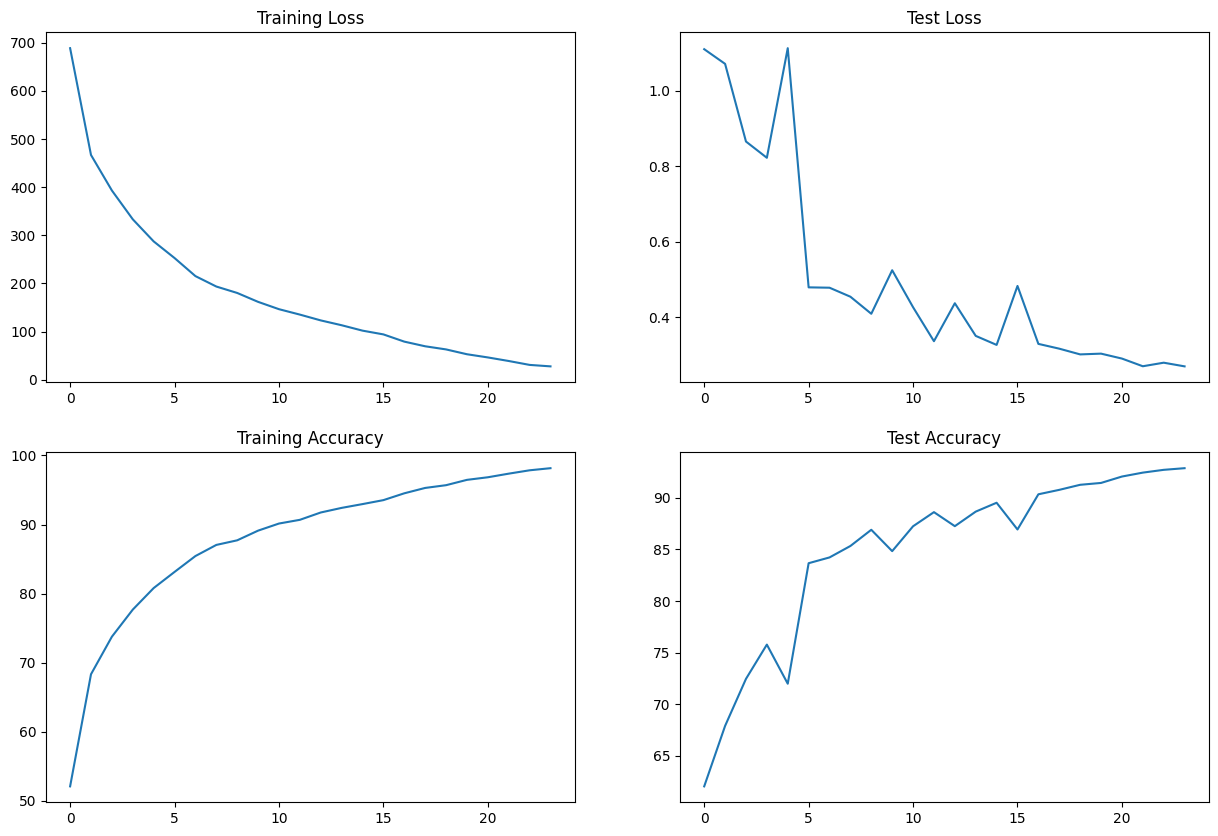

In [9]:
from visualise import draw_graphs
draw_graphs()

Confusion matrix, without normalization


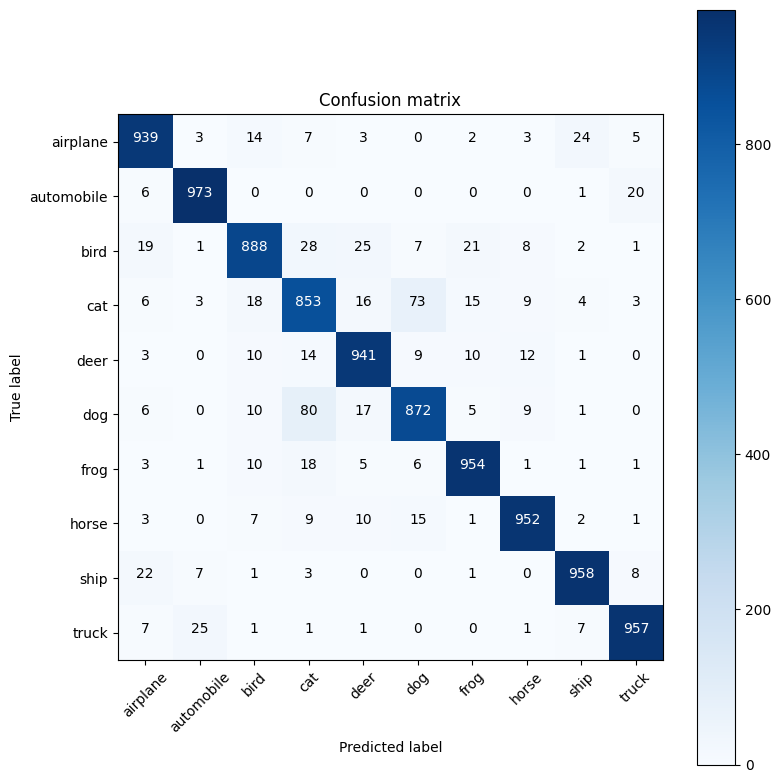

In [10]:
from utils import prepare_confusion_matrix, get_all_predictions
from visualise import plot_confusion_matrix

all_preds, all_targets = get_all_predictions(model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)

In [12]:
from utils import get_incorrrect_predictions, load_weights_from_path

model = load_weights_from_path(model, "trained_model/cifar10.pth")

incorrect = get_incorrrect_predictions(model, test_loader, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total Incorrect Predictions 713


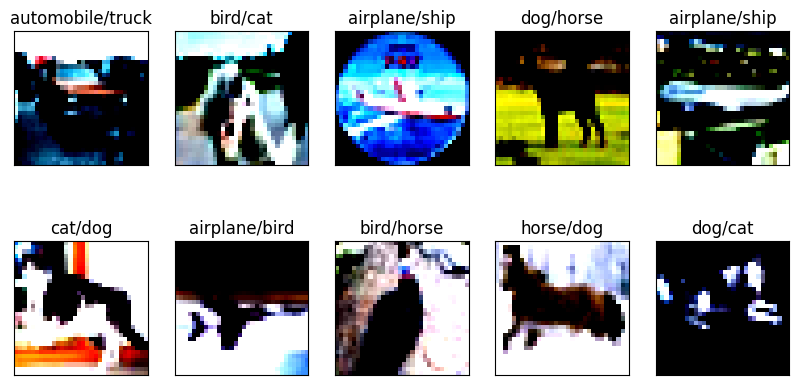

In [13]:
from visualise import plot_incorrect_predictions

labels_mapping = {idx:cls for cls, idx in class_map.items()}
plot_incorrect_predictions(incorrect, labels_mapping, 10)